# Model accuracy, SHAP and feature selection using a threshold of 5 min APGAR < 7

In [1]:
threshold = 7 # Positive class is less than threshold

In [2]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
import pandas as pd
import shap

from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from xgboost import XGBClassifier

import math

## Load data

In [3]:
data = pd.read_csv('./data/processed_data_for_model_one_hot.csv')

In [4]:
prop_less_threshold = np.mean(data['apgar5'] < threshold)
print (f'Proportion < {threshold} = {prop_less_threshold:0.4f}')

Proportion < 7 = 0.0130


Drop hopsitals from this model.

In [5]:
drop_hospitals = True

if drop_hospitals:
    selected_cols = []
    for col in list(data):
        if col[0:8] == 'hospital':
            pass
        else:
            selected_cols.append(col)
    
    data = data[selected_cols]

Split X and y

In [6]:
y = data['apgar5'] < threshold
y.rename_axis("target", inplace=True)
X = data.drop('apgar5', axis=1)

## K-fold accuracy measurement

In [7]:
# Set up splits
number_of_splits = 3
skf = StratifiedKFold(n_splits = number_of_splits)
skf.get_n_splits(X, y)

3

In [8]:
# Set up lists for observed and predicted
observed = []
predicted_proba = []
predicted = []
importances = []

# Loop through the k-fold splits
counter = 0
for train_index, test_index in skf.split(X, y):
    counter += 1
    
    # Get X and Y train/test
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    # Balance training data with random oversampling of minority class
    ros = RandomOverSampler(random_state=42)
    X_train, y_train = ros.fit_resample(X_train, y_train)

    # Fit model
    model = XGBClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Get predicted probabilities
    y_probs = model.predict_proba(X_test)[:,1]
    y_class = model.predict(X_test)
    observed.append(y_test)
    predicted_proba.append(y_probs)
    
    # Print accuracy
    tp = np.sum((y_class == 1) & (y_test == 1))
    fp = np.sum((y_class == 1) & (y_test == 0))
    tn = np.sum((y_class == 0) & (y_test == 0))
    fn = np.sum((y_class == 0) & (y_test == 1))

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    balanced_accuracy = (sensitivity + specificity) / 2

    accuracy = np.mean(y_class == y_test)
    print (
        f'Run {counter}, accuracy: {accuracy:0.3f}, sensitivity: {sensitivity:0.3f}, ' +
        f'specificity: {specificity:0.3f}, balanced accuracy: {balanced_accuracy:0.3f}')

Run 1, accuracy: 0.855, sensitivity: 0.500, specificity: 0.859, balanced accuracy: 0.680
Run 2, accuracy: 0.857, sensitivity: 0.467, specificity: 0.863, balanced accuracy: 0.665
Run 3, accuracy: 0.861, sensitivity: 0.491, specificity: 0.866, balanced accuracy: 0.678


Calculate ROC AUC

In [9]:
# Set up lists for results
k_fold_fpr = [] # false positive rate
k_fold_tpr = [] # true positive rate
k_fold_thresholds = [] # threshold applied
k_fold_auc = [] # area under curve

# Loop through k fold predictions and get ROC results 
for i in range(number_of_splits):
    # Get fpr, tpr and thresholds foir each k-fold from scikit-learn's ROC method
    fpr, tpr, thresholds = roc_curve(observed[i], predicted_proba[i])
    # Use scikit-learn's method for calulcating auc
    roc_auc = auc(fpr, tpr)
    # Store results
    k_fold_fpr.append(fpr)
    k_fold_tpr.append(tpr)
    k_fold_thresholds.append(thresholds)
    k_fold_auc.append(roc_auc)
    # Print auc result
    print (f'Run {i} AUC {roc_auc:0.4f}')

# Show mean area under curve  
mean_auc = np.mean(k_fold_auc)
sd_auc = np.std(k_fold_auc)
print (f'\nMean AUC: {mean_auc:0.4f}')
print (f'SD AUC: {sd_auc:0.4f}')

Run 0 AUC 0.7364
Run 1 AUC 0.7201
Run 2 AUC 0.7311

Mean AUC: 0.7292
SD AUC: 0.0068


## SHAP

Fit new model to 75% of data and show SHAP for 25% test set.


In [10]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

# Balance training data with random oversampling
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

# Fit model and get SHAP
model.fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values_extended = explainer(X_test)
shap_values = explainer.shap_values(X_test)
shap_values_extended[0]

.values =
array([ 1.9524553e-01,  2.1783659e-02,  1.8412751e-03, -2.8106633e-03,
       -1.6265427e-01,  1.1803250e-01,  2.1043900e-01, -2.8794238e-01,
        3.0739228e-03,  1.3538525e-01,  2.1781699e-01, -1.3619574e-02,
       -2.5934899e-01,  3.1061126e-03, -1.0889297e-02,  3.0868943e-04,
       -7.4896389e-03,  2.3274672e-04, -3.7707407e-02, -9.0967398e-03,
       -1.0386665e-01,  7.1154889e-03, -2.2481723e-01, -5.7485308e-02,
        6.6681011e-03, -3.9235793e-02, -3.8892364e-03, -3.9961871e-02,
        1.8166004e-02,  2.5854874e-02,  5.4652011e-03,  5.9686694e-04,
       -5.8020148e-02, -9.0686204e-03,  0.0000000e+00, -2.2277517e-02,
       -6.5344637e-03, -6.0274053e-02], dtype=float32)

.base_values =
0.0061824587

.data =
array([0, 0, 2, False, False, 21, 22, 40, True, False, True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, True, False, False, False, False, False, False, False,
       False, True, False, False, False, Fal

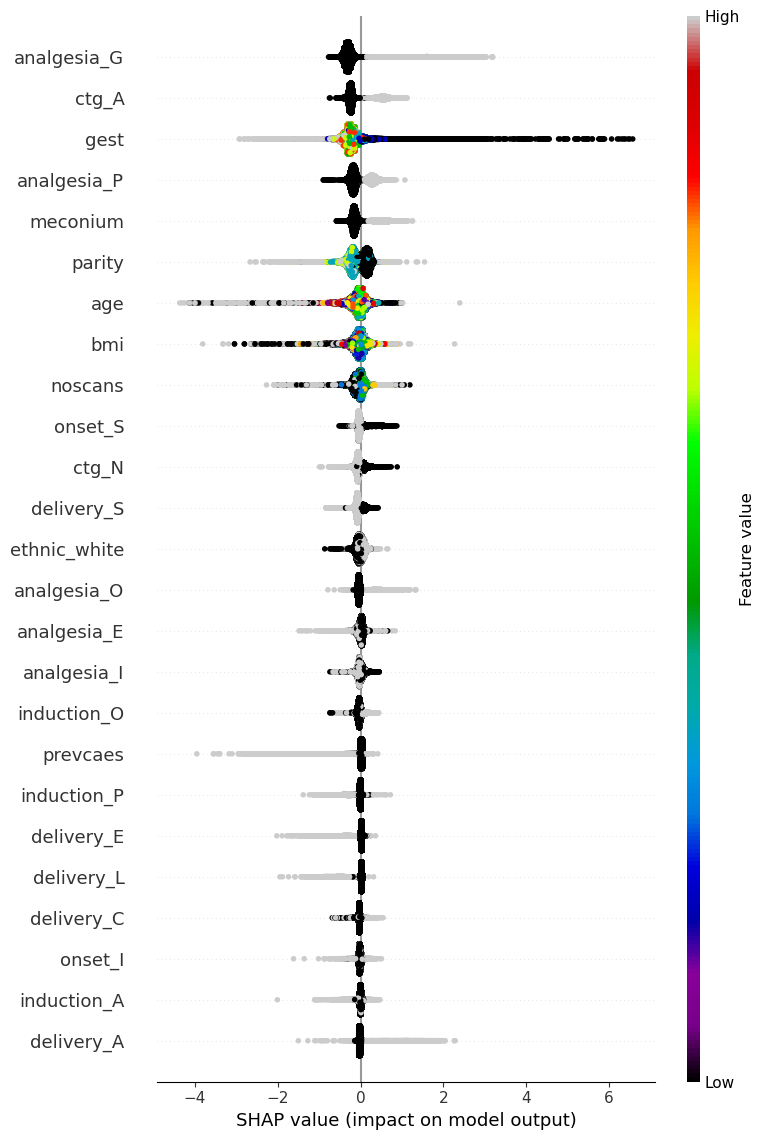

In [11]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values=shap_values, 
                  features=X_test,
                  feature_names=list(X_test),
                  max_display=25,
                  cmap=plt.get_cmap('nipy_spectral'), show=False)

plt.savefig(f'./output/shap_beeswarm_threshold_{threshold}.jpg', dpi=300)
plt.show()

In [12]:
df = pd.DataFrame(index=list(X))
df['feature_index'] = np.arange(len(list(X)))
df['mean_shap'] = np.mean(shap_values, axis=0)
df['mean_abs_shap'] = np.mean(np.abs(shap_values), axis=0)
df.sort_values('mean_abs_shap', ascending=False, inplace=True)

top_shap = list(df.index)
df.head(15)

,feature_index,mean_shap,mean_abs_shap
analgesia_G,12,-0.197820,0.382631
ctg_A,22,-0.085143,0.309023
gest,7,-0.188674,0.286627
analgesia_P,10,-0.035179,0.210679
meconium,4,-0.049862,0.206194
parity,0,-0.064172,0.188388
age,6,-0.091820,0.169399
bmi,5,-0.092078,0.162854
noscans,2,-0.060011,0.112587
onset_S,37,0.022604,0.086971


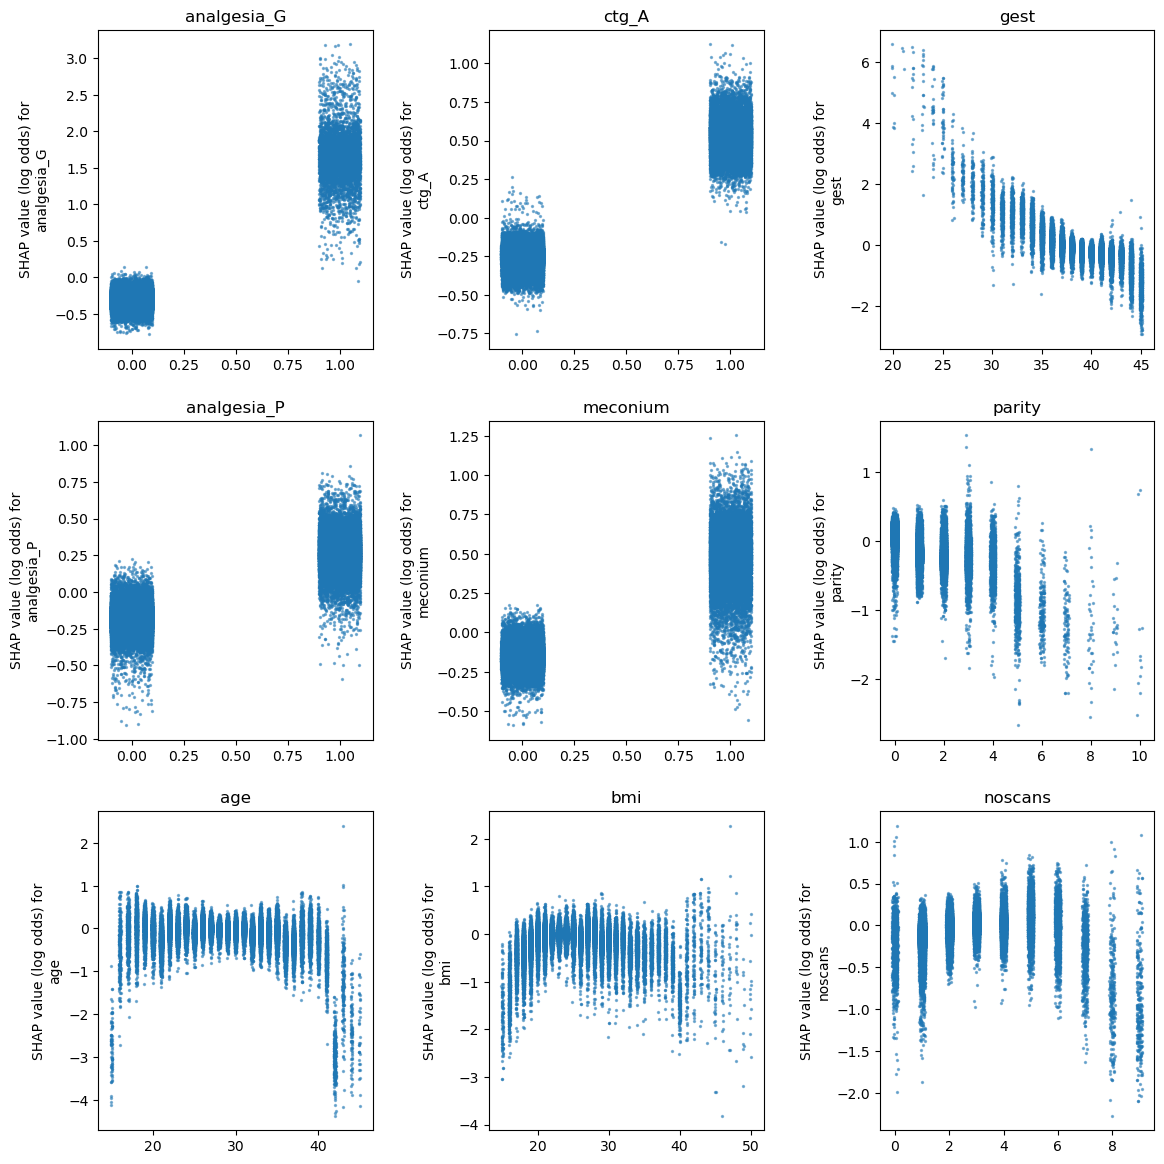

In [13]:
feat_to_show = top_shap[0:9]

fig = plt.figure(figsize=(12,12))
for n, feat in enumerate(feat_to_show):
    feat_index = int(df.loc[feat]['feature_index']) 
    ax = fig.add_subplot(3,3,n+1)

    shap_data = shap_values_extended[:].values[:,feat_index]
    feature_data = shap_values_extended[:].data[:,feat_index]

    jitter = -0.1 + (np.random.rand(len(feature_data))*0.2)

    ax.scatter(feature_data + jitter, shap_data, alpha=0.5, s=2)  
    
    ax.set_ylabel(f'SHAP value (log odds) for\n{feat}')
    ax.set_title(feat)
    
plt.tight_layout(pad=2)
plt.savefig(f'./output/shap_scatter_threshold_{threshold}.jpg', dpi=300)

plt.show()


Violin plots

In [1]:
# Function to format axes

def set_ax(ax, category_list, feat, rotation=0):
    '''
    ax [matplotlib axis object] = matplotlib axis object
    category_list [list] = used for the xtick labels (the grouping of the data)
    feat [string] = used in the axis label, the feature that is being plotted
    rotation [integer] = xtick label rotation

    reeturn [matplotlib axis object]
    
    resource: 
    https://matplotlib.org/3.1.0/gallery/statistics/customized_violin.html
    '''
    # Set the axes ranges and axes labels
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(category_list) + 1))
    if len(category_list)> 8:
        ax.set_xticklabels(category_list, rotation=rotation, fontsize=8)
    else:
        ax.set_xticklabels(category_list, rotation=rotation, fontsize=8)
        
    ax.set_xlim(0.25, len(category_list) + 0.75)
    ax.set_ylabel(f'SHAP values for {feat}', fontsize=10)
    ax.set_xlabel(f'Feature values for {feat}', fontsize=10)
    return(ax)


In [2]:
# Main function to create a grid of violin plots

def create_grid_of_violin_plots(features_violin, 
                                shap_values_extended,
                                threshold
                                ):
    # Feature Age needs special consideration. It needs the x ticks to be created,
    # as the other features with over 50 unique values, but age is already grouped 
    # for the model (into 5yr groups) and so is treated as the other type.

    # Create figure
    fig = plt.figure(figsize=(12,14), constrained_layout=True)
    # A subplot showing violin plot for each feature.
    # First prepare the fature data for the violin plot: if feature has more than 
    # 50 unique values then assume it needs to be binned (a violin for each bin)

    # Determine number of rows of subplots by rounding up
    ncols = 3
    nrows = math.ceil(len(features_violin)/ncols)

    # Through each feature
    for n, feat in enumerate(features_violin):    
        # Get data adn SHAP values
        feature_data = shap_values_extended[:, feat].data
        feature_shap = shap_values_extended[:, feat].values

        # number of unique values
        n_unique = np.unique(feature_data).shape[0]

        # If feature has more that 50 unique values, then assume it needs to be 
        # binned (otherwise assume they are unique categories)
        if n_unique > 50:
            # bin the data, create a violin per bin
            
            # settings for the plot
            rotation = 45
            step = 5
            n_bins = np.int((feature_data.max())/step)

            # create list of bin values
            bin_list = [(i*step) for i in range(n_bins)]
            bin_list.append(feature_data.max())

            if feat == "bmi":
                # Make 0 a unique category
                if bin_list[0] == 0:
                    bin_list[0] = 0.1
                bin_list.insert(0, 0)

            n_bins = len(bin_list)

            # Number of instances per bin
            counts, edges = np.histogram(feature_data, bins=bin_list, density=False)
            # create list of bins (the unique categories)
            category_list = [f'{bin_list[i]}-{bin_list[i+1]}' for i in range(n_bins-1)]

     
            # bin the feature data
            feature_data = pd.cut(feature_data, bin_list, labels=category_list, 
                                right=False)

            # create a list, each entry contains the corresponsing SHAP value for that 
            # category (or bin). A violin will represent each list.    
            shap_per_category = []
            for category in category_list:
                mask = feature_data == category
                shap_per_category.append(feature_shap[mask])

        else:
            # create a violin per unique value
            
            # settings for the plot
            rotation = 90
            
            # create list of unique categories in the feature data
            # Age needs to keep its decimal value (midpoint between 5 yrs)
            category_list = np.unique(feature_data)

            # create a list, each entry contains the corresponsing SHAP value for that 
            # category (or bin). A violin will represent each list.    
            count = []
            shap_per_category = []
            for category in category_list:
                mask = feature_data == category
                shap_per_category.append(feature_shap[mask])
                count.append(mask.sum())

            category_list = [f'{category_list[i]}' for i in range(len(category_list))]
                
        # create violin plot
        ax = fig.add_subplot(nrows,ncols,n+1)

        nans = [float('nan'), float('nan')] # requires at least 2 nans
        ax.violinplot([val if val.any() else nans for val in shap_per_category],
                      showmeans=True, showextrema=False, widths=0.9)

        # Add line at Shap = 0
        feature_values = shap_values_extended[:, feat].data
        ax.plot([0, len(feature_values)], [0,0],c='0.5')   

        # customise the axes
        ax = set_ax(ax, category_list, feat, rotation=rotation)
        plt.subplots_adjust(bottom=0.15, wspace=0.05)

        # Only show  up to 12 tickmarks
        max_ticks = 12
        if len(category_list) > max_ticks:
            skip = math.ceil(len(category_list)/max_ticks)
            ax.set_xticks(np.arange(1, len(category_list)+1, skip))
            ax.set_xticklabels(category_list[0::skip])   

        # Add title
        ax.set_title(feat)
        
    plt.tight_layout(pad=2)

    plt.savefig(f'./output/shap_violin_threshold_{threshold}.jpg', dpi=300)

    plt.show()
    return()

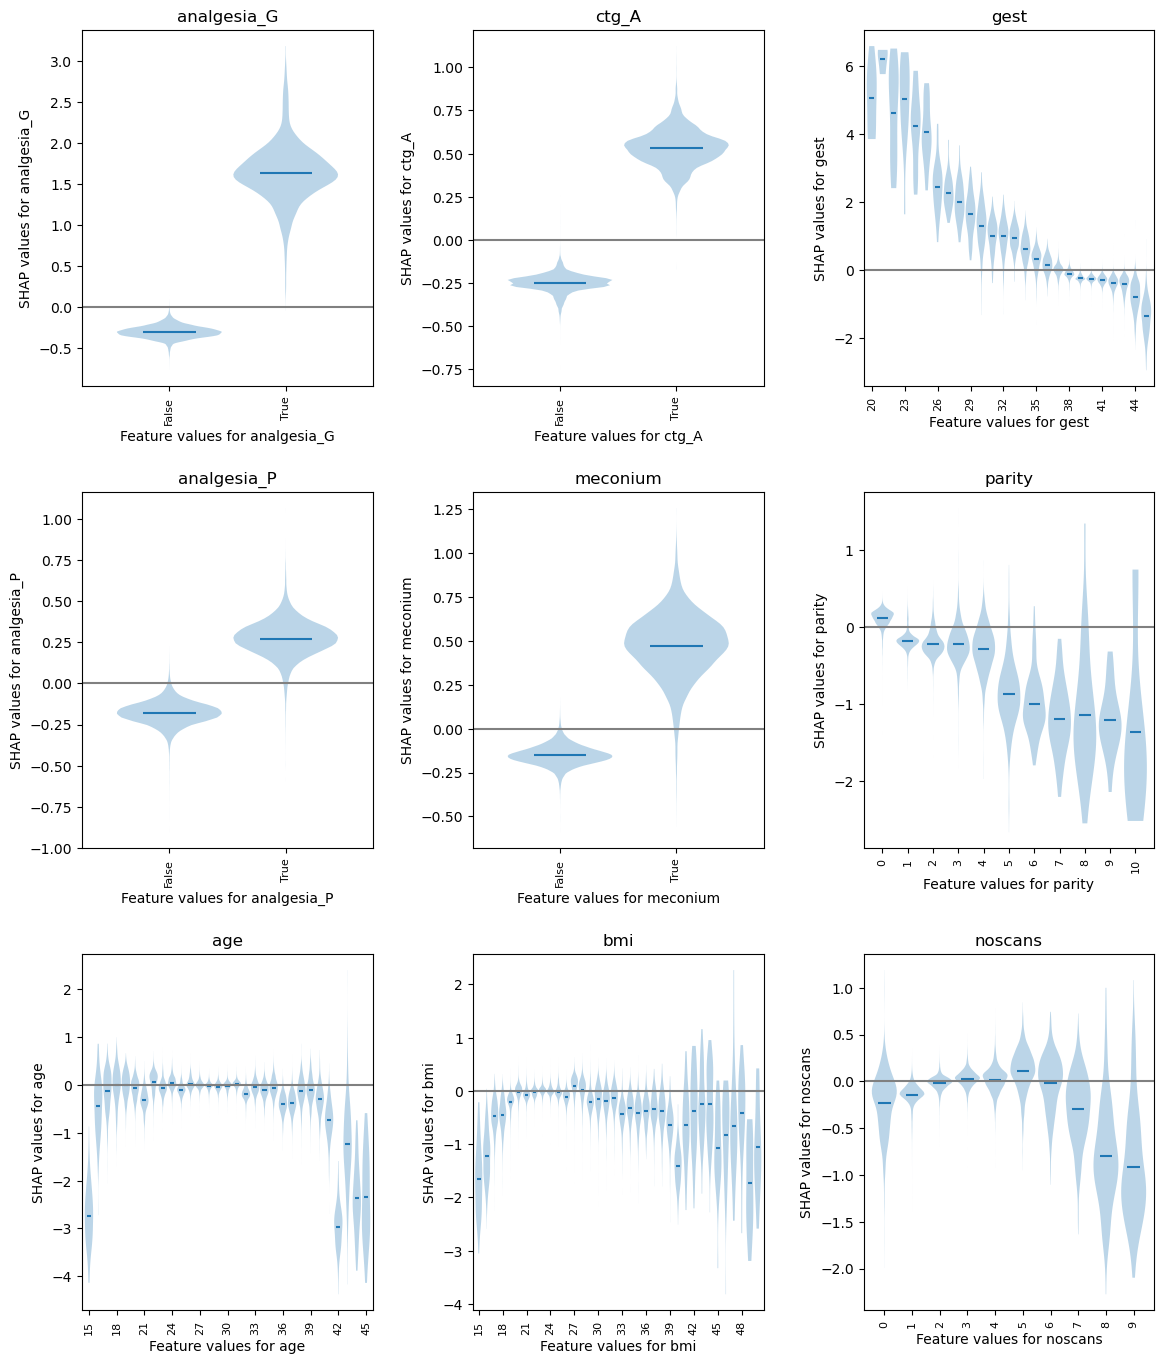

()

In [16]:
create_grid_of_violin_plots(feat_to_show,
                            shap_values_extended,
                            threshold
                            )

## Confusion matrix

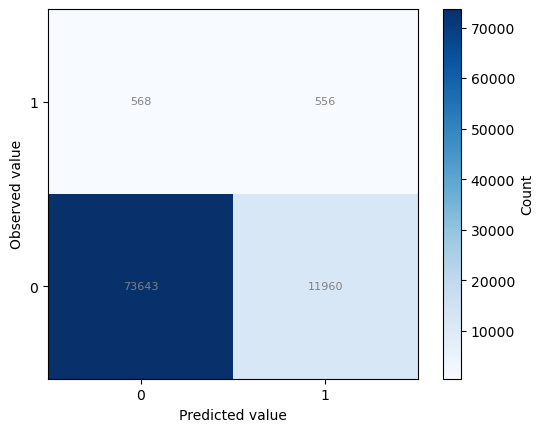

In [17]:
# Calculate values for confusion matrix
y_predict = model.predict(X_test)
cm = confusion_matrix(y_test, y_predict)

fig = plt.figure()
ax = fig.add_subplot()

# Legend height
shrink = 1

# Visualize the confusion matrix with colors
heatmap = ax.imshow(cm, cmap=plt.cm.Blues, origin='lower')
plt.colorbar(heatmap, shrink=shrink, ax=ax, alpha=0.5, label='Count')
#Add values to plot
for i in range(len(cm)):
    for j in range(len(cm[0])):
        ax.text(j, i, cm[i][j], ha='center', va='center', color='grey', size=8)
ax.set_xlabel('Predicted value')
ax.set_ylabel('Observed value')
loc = plticker.MultipleLocator(base=1.0)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
plt.show()